### 0. Imports

In [205]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.data_preparation as dp
import src.soporte_ajuste_clasificacion as sac
import src.data_visualization_support as dvs

# Machine Learning tools
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import  RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV

import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline



# encoding
# -----------------------------------------------------------------------
from sklearn.preprocessing import  OneHotEncoder
import category_encoders as ce
# set category encoder compatibility
import sklearn
sklearn.set_config(transform_output="pandas")

# scaling
# -----------------------------------------------------------------------
from sklearn.preprocessing import  RobustScaler, StandardScaler


# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr

# model tracking
# -----------------------------------------------------------------------
import mlflow

# definir semilla random
# -----------------------------------------------------------------------
seed = 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction - Employee Retention - Model Evaluation

## 1.1 Data import

In [40]:
employee_attrition = pd.read_pickle("../data/explored/employee_attrition_explored.pkl")
employee_attrition.duplicated(keep=False).sum()

4306

## 2. Set experiment tracking with MLflow

Set MLFlow tracking folder, activate autolog and set an experiment name for tracking.

In [41]:
# mlflow.set_tracking_uri("../model_tracking")  # Local directory
# mlflow.set_experiment("employee_retention")
# mlflow.autolog()

# 3. Model evaluation

## 3.1 Experiment 1 - baseline

### 3.1.1 Data preparation

Data preparation for load, cleaning and correction of errors found throughout the 1_exploration_cleaning, 2_EDA and 3_preprocessing notebooks have been integrated into a load and clean function, available at ``src/data_preparation.py``.

In [172]:
list_of_paths = ["../data/general_data.csv","../data/employee_survey_data.csv","../data/manager_survey_data.csv"]

employee_attrition = dp.load_and_clean(list_of_paths, "EmployeeID")
employee_attrition

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,gender,joblevel,jobrole,...,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,1.0,6,1.0,0,0,3.0,4.0,2.0,3,3
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,6.0,3,5.0,1,4,3.0,2.0,4.0,2,4
2,32,0,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,5.0,2,5.0,0,3,2.0,2.0,1.0,3,3
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,13.0,5,8.0,7,5,4.0,4.0,3.0,2,3
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,9.0,2,6.0,0,4,4.0,1.0,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,36,0,Travel_Rarely,Research & Development,2,3,Life Sciences,Male,2,Sales Representative,...,5.0,2,1.0,0,0,2.0,4.0,3.0,3,3
4305,45,0,Travel_Rarely,Sales,1,4,Technical Degree,Male,1,Research Scientist,...,20.0,3,17.0,0,10 or more,2.0,2.0,nan,3,3
4332,31,0,Travel_Rarely,Sales,2,5,Life Sciences,Male,2,Sales Representative,...,7.0,3,4.0,0,2,nan,4.0,3.0,4,3
4395,40,0,Travel_Rarely,Research & Development,2,3,Life Sciences,Male,1,Manufacturing Director,...,9.0,4,9.0,4,7,1.0,4.0,3.0,2,3


### 3.1.2 Define target and predictors

In [173]:
y = employee_attrition["attrition"]
X = employee_attrition.drop(columns="attrition")

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

### 3.1.3 Data preprocessing

- Missing: Median imputation for numerical features. Mode for categorical.
- Outliers: False.
- Encoding: One hot encoder for <= 3 categories. Target for others.
- Scaling: False. (Only tree based models will be used)

Setting the conditions for data preprocessing:

In [174]:
categorical = X.select_dtypes("object").columns.to_list()

# current numpy version doesn't work well with np.number for this:
numerical = X.select_dtypes(["int64","float64"]).columns.to_list()

all_columns = X.columns.to_list()

columns_one_hot = [col for col in categorical if X[col].nunique() <= 3]
columns_target =[col for col in categorical if X[col].nunique() > 3]


imputer = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

# Combine into a pipeline to later append the model
preprocessing_pipeline_target = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

Checking the preprocessing pipeline:

In [45]:
preprocessing_pipeline_target.fit_transform(X,y).sample(7)

,age,distancefromhome,monthlyincome,totalworkingyears,yearsatcompany,businesstravel_Travel_Rarely,businesstravel_Travel_Frequently,businesstravel_Non-Travel,department_Sales,department_Research & Development,...,percentsalaryhike,trainingtimeslastyear,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating_3,performancerating_4
47,36.0,5.0,85780.0,11.0,9.0,0,0,1,0,1,...,0.179061,0.12782,0.192,0.094832,0.148026,0.165541,0.140127,0.154341,0,1
583,24.0,7.0,25760.0,6.0,4.0,1,0,0,1,0,...,0.186791,0.172414,0.137931,0.145604,0.133333,0.165541,0.140127,0.154341,1,0
1219,30.0,11.0,171690.0,1.0,1.0,1,0,0,0,1,...,0.186791,0.174873,0.192,0.313793,0.133333,0.166667,0.140127,0.154341,1,0
751,58.0,22.0,24500.0,32.0,9.0,1,0,0,1,0,...,0.154206,0.174873,0.137931,0.136817,0.133333,0.229236,0.140127,0.154341,1,0
805,29.0,10.0,128080.0,10.0,10.0,1,0,0,1,0,...,0.172727,0.057833,0.192,0.116516,0.139004,0.166667,0.140127,0.154341,1,0
740,26.0,2.0,53040.0,5.0,4.0,1,0,0,0,1,...,0.163874,0.174873,0.137931,0.14637,0.247492,0.112245,0.140127,0.154341,0,1
292,23.0,13.0,42210.0,5.0,4.0,1,0,0,1,0,...,0.134529,0.12782,0.192,0.145604,0.148026,0.229236,0.179487,0.154341,1,0


### 3.1.4 Models to compare

The following models with its corresponding parameters will be crossvalidated to find the smallest root_mean_squared_error.

In [175]:
models = {
    'decision_tree': (
        DecisionTreeClassifier(random_state=seed),
        {
            'classifier__max_depth': [None, 5, 10, 15],
            'classifier__min_samples_split': [5, 10, 15],
            'classifier__min_samples_leaf': [2, 5, 10],
            'classifier__max_leaf_nodes': [20, 30, None],
            'classifier__max_features': ['sqrt', 'log2']
        }
    ),

    'random_forest': (
        RandomForestClassifier(random_state=seed, n_jobs=-1),
        {
            'classifier__n_estimators': [50, 100, 150, 200],
            'classifier__max_depth': [10, 15, 20, 25],
            'classifier__min_samples_split': [2, 5, 10, 15],
            'classifier__min_samples_leaf': [1, 5, 10],
            'classifier__bootstrap': [True, False]
        }
    ),

    'xgboost': (
        XGBClassifier(n_jobs=-1, random_state=seed),
        {
            'classifier__n_estimators': [50, 75],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3,5],
            'classifier__min_child_weight': [1, 2],
            'classifier__colsample_bytree': [0.8,0.9],
            'classifier__gamma': [0.05, 1, 1.5],
            'classifier__reg_alpha': [0.05, 0.1],
            'classifier__reg_lambda': [1],
        }
    )

# {'classifier__colsample_bytree': 0.85,
#  'classifier__gamma': 1.5,
#  'classifier__learning_rate': 0.05,
#  'classifier__max_depth': 3,
#  'classifier__min_child_weight': 3,
#  'classifier__n_estimators': 75,
#  'classifier__reg_alpha': 0.05,
#  'classifier__reg_lambda': 1}

}


### 3.1.5 Run experiment

Perform train and test split. Define a stratified kfold cross validation to improve metric robustness in face of target imbalance. Optimize for minimal average_precision_score, which is the equivalent of the area under the Precision-Recall curve, which is more informative than AUC for imbalanced datasets.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
score = "average_precision"

verbosity = 2

Evaluate Decision Tree:

In [182]:
analista_clasificacion_1 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration1")

analista_clasificacion_1.ajustar_modelo("decision_tree", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["decision_tree"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_1.calcular_metricas("decision_tree")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.878378,0.868413,0.878378,0.857853,0.416961,0.892812,0.642511,0.324669,0.062769,12.0
test,0.819048,0.760918,0.819048,0.779788,0.074723,0.647774,0.256344,0.324669,0.062769,12.0


Evaluate Random Forest:

In [183]:
analista_clasificacion_1.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_1.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.965819,0.967156,0.965819,0.964124,0.861263,0.999916,0.999588,0.91391,0.156659,12.0
test,0.857143,0.846509,0.857143,0.812635,0.198473,0.763396,0.525138,0.91391,0.156659,12.0


Evaluate Xgboost:

In [184]:
analista_clasificacion_1.ajustar_modelo("xgboost", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["xgboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_1.calcular_metricas("xgboost")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.880763,0.885281,0.880763,0.852854,0.385470,0.904487,0.735957,0.304906,0.065993,12.0
test,0.857143,0.840482,0.857143,0.816371,0.217499,0.702340,0.413048,0.304906,0.065993,12.0


In [ ]:
for model in models.keys():
    print(f"{model} - best params:")
    display(analista_clasificacion_1.resultados[model]["best_params"])

decision_tree - best params:


{'classifier__max_depth': 10,
 'classifier__max_features': 'log2',
 'classifier__max_leaf_nodes': None,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 15}

random_forest - best params:


{'classifier__bootstrap': True,
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 200}

xgboost - best params:


{'classifier__colsample_bytree': 0.9,
 'classifier__gamma': 0.05,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__min_child_weight': 2,
 'classifier__n_estimators': 50,
 'classifier__reg_alpha': 0.05,
 'classifier__reg_lambda': 1}

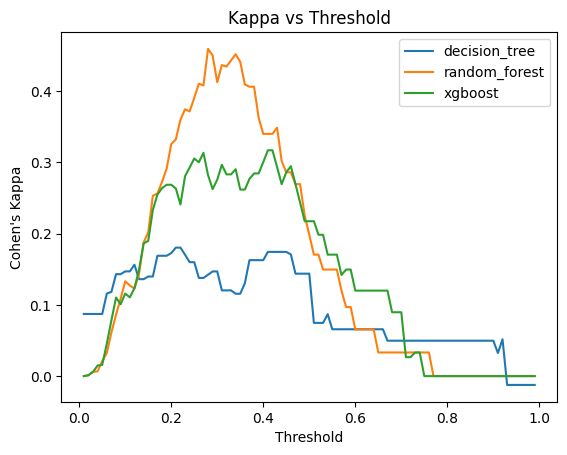

In [ ]:
analista_clasificacion_1.plot_cohens_kappa(models.keys())

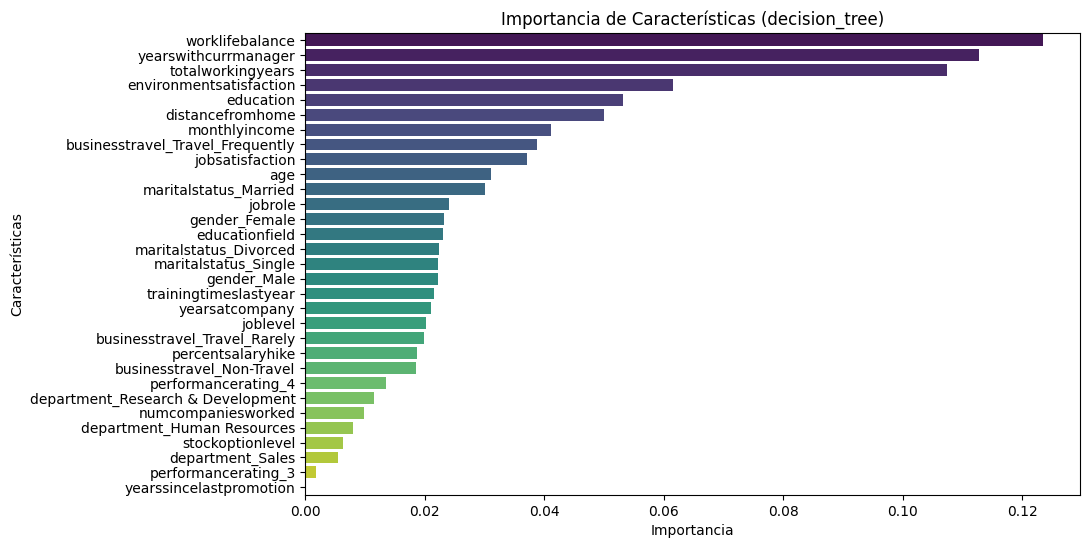

In [ ]:
analista_clasificacion_1.importancia_predictores("decision_tree", pipeline=True)

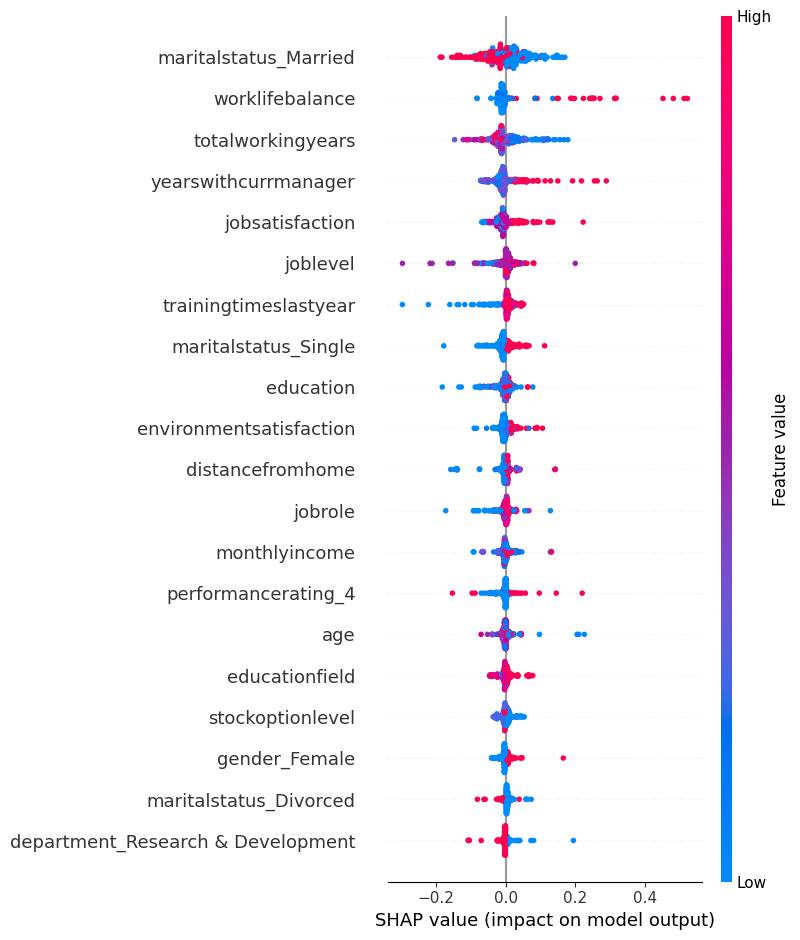

In [ ]:
analista_clasificacion_1.plot_shap_summary("decision_tree", pipeline=True)

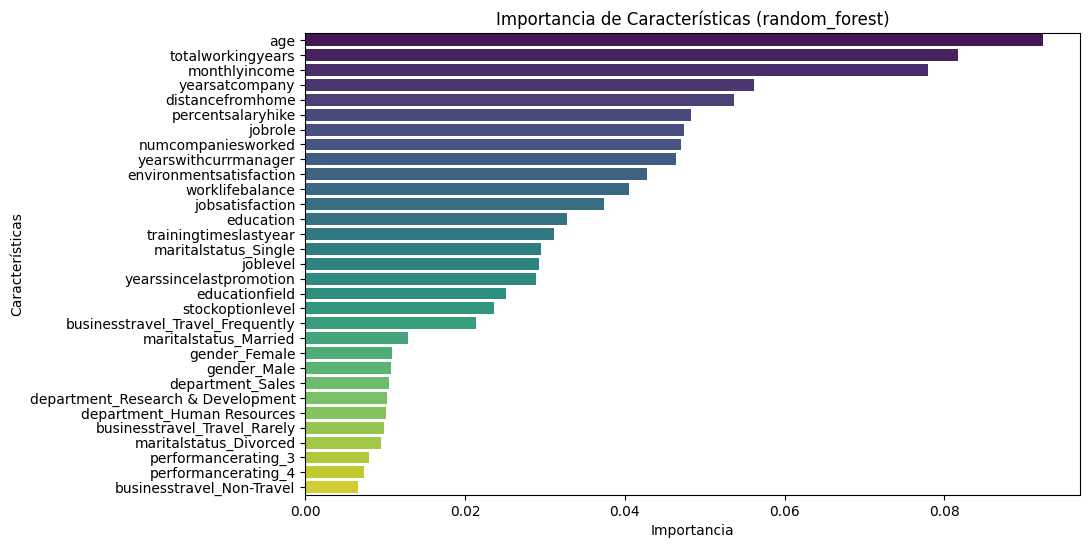

In [ ]:
analista_clasificacion_1.importancia_predictores("random_forest", pipeline=True)

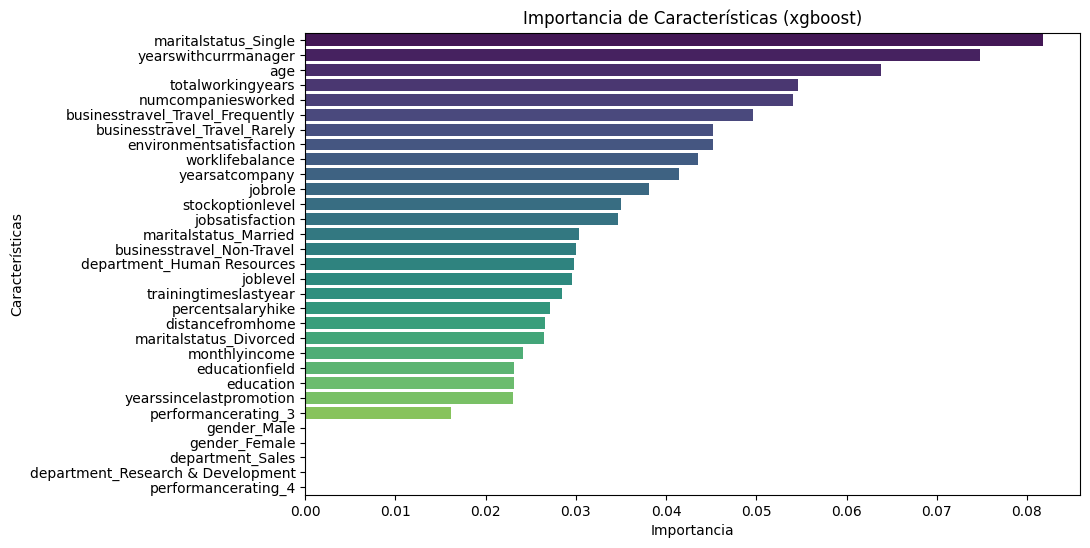

In [ ]:
analista_clasificacion_1.importancia_predictores("xgboost", pipeline=True)

## 3.2 Experiment 2

Same, only changing the TargetEncoder for a CatBoost encoder.

In [ ]:
analista_clasificacion_2 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration2")

In [58]:
preprocessing_pipeline_catboost_encoder = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.CatBoostEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

In [59]:
analista_clasificacion_2.ajustar_modelo("decision_tree", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["decision_tree"][1], 
                                        cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("decision_tree")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.841812,0.800990,0.841812,0.791875,0.118533,0.667815,0.335310,0.265975,0.081883,12.0
test,0.825397,0.761969,0.825397,0.779821,0.065786,0.647283,0.272054,0.265975,0.081883,12.0


In [60]:
analista_clasificacion_2.ajustar_modelo("xgboost", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["xgboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("xgboost")

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.860890,0.861427,0.860890,0.817911,0.229474,0.793584,0.544504,0.319036,0.091821,12.0
test,0.853968,0.833776,0.853968,0.810415,0.190503,0.650943,0.383334,0.319036,0.091821,12.0


In [61]:
analista_clasificacion_2.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_catboost_encoder, 
                                        param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_2.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.875199,0.883453,0.875199,0.842119,0.336493,0.922986,0.757400,1.201223,0.222251,12.0
test,0.853968,0.833776,0.853968,0.810415,0.190503,0.726792,0.429337,1.201223,0.222251,12.0


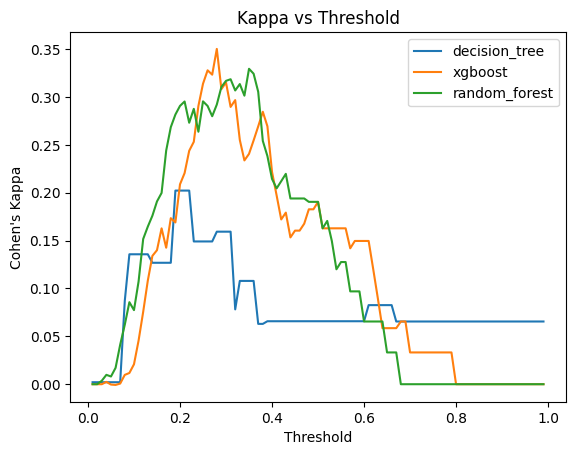

In [164]:
analista_clasificacion_2.plot_cohens_kappa(["decision_tree", "xgboost","random_forest"])

## 3.3 Experiment 3

Catboost, not optimized. A small number of iterations will be tested as it is a quite intensive algorithm.

No encoding is needed.

In [222]:
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__iterations': [50,100,150,300,500,1000]
        }
    )

preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer)
])

In [ ]:
analista_clasificacion_3 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="catboost - n_iterations")

analista_clasificacion_3.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_3.calcular_metricas("catboost")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [65]:
display(analista_clasificacion_3.resultados["catboost"]["mejor_modelo"]["classifier"].get_best_iteration())
analista_clasificacion_3.resultados["catboost"]["mejor_modelo"]["classifier"].get_params()

None

{'verbose': 100,
 'custom_metric': 'PRAUC',
 'eval_metric': 'PRAUC',
 'random_state': 42,
 'early_stopping_rounds': 50,
 'cat_features': ['businesstravel',
  'department',
  'education',
  'educationfield',
  'gender',
  'joblevel',
  'jobrole',
  'maritalstatus',
  'numcompaniesworked',
  'percentsalaryhike',
  'stockoptionlevel',
  'trainingtimeslastyear',
  'yearssincelastpromotion',
  'yearswithcurrmanager',
  'environmentsatisfaction',
  'jobsatisfaction',
  'worklifebalance',
  'jobinvolvement',
  'performancerating'],
 'iterations': 150}

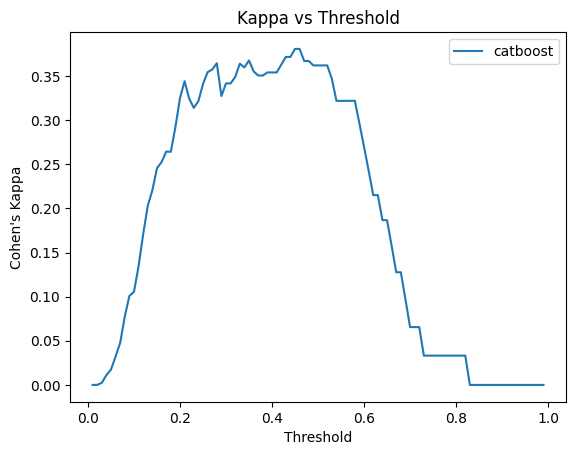

In [66]:
analista_clasificacion_3.plot_cohens_kappa(["catboost"])

## 3.4 Experiment 4

Catboost, optimized. 



In [67]:
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__depth': [6,8,10],
            'classifier__l2_leaf_reg': [1, 3, 5],
            'classifier__border_count': [32, 64],
            'classifier__bagging_temperature': [0.5, 1],
            'classifier__iterations': [50,100,150]
        }
    )

imputer_catboost = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy="constant", fill_value="NaN"), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer_catboost)
])

In [ ]:
analista_clasificacion_4 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration4")

analista_clasificacion_4.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_4.calcular_metricas("catboost")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0:	learn: 0.3038797	total: 69.6ms	remaining: 10.4s
100:	learn: 0.9759195	total: 7.26s	remaining: 3.52s
149:	learn: 0.9974526	total: 10.6s	remaining: 0us


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.911765,0.920157,0.911765,0.897254,0.579188,0.983217,0.945950,17.572955,0.017063,12.0
test,0.860317,0.852407,0.860317,0.818658,0.225698,0.762792,0.504613,17.572955,0.017063,12.0


Somehow, Catboost works best when no other hyperparameters other than the iterations number is modified. Or at the very least, there is one parameter that should not be modified (learning rate is for sure one of them) and throws off the whole optimization.

In [69]:
display(analista_clasificacion_4.resultados["catboost"]["mejor_modelo"]["classifier"].get_best_iteration())
analista_clasificacion_4.resultados["catboost"]["mejor_modelo"]["classifier"].get_params()

None

{'verbose': 100,
 'custom_metric': 'PRAUC',
 'eval_metric': 'PRAUC',
 'random_state': 42,
 'early_stopping_rounds': 50,
 'cat_features': ['businesstravel',
  'department',
  'education',
  'educationfield',
  'gender',
  'joblevel',
  'jobrole',
  'maritalstatus',
  'numcompaniesworked',
  'percentsalaryhike',
  'stockoptionlevel',
  'trainingtimeslastyear',
  'yearssincelastpromotion',
  'yearswithcurrmanager',
  'environmentsatisfaction',
  'jobsatisfaction',
  'worklifebalance',
  'jobinvolvement',
  'performancerating'],
 'bagging_temperature': 0.5,
 'border_count': 32,
 'depth': 10,
 'iterations': 150,
 'l2_leaf_reg': 1}

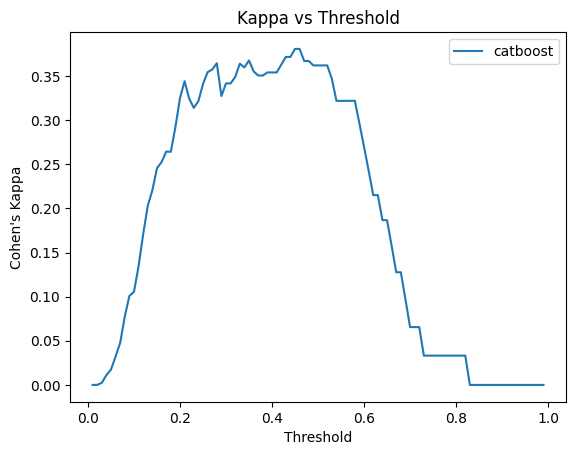

In [70]:
analista_clasificacion_3.plot_cohens_kappa(["catboost"])

## 3.5 Experiment 5

Probando balanceos de parámetro

In [186]:
# redefine catboost for simpler first model.
models["catboost"] = (
        CatBoostClassifier(thread_count=-1, random_state=seed, cat_features=categorical),
        {
            'classifier__iterations': [50,100,150],
            'classifier__auto_class_weights': ['Balanced']
        }
    )

imputer_catboost = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median'), numerical),
        ('cat_imputer', SimpleImputer(strategy="most_frequent"), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

preprocessing_pipeline_catboost = Pipeline([
    ('imputer', imputer_catboost)
])

#  Random stays equal but gets added 
models["random_forest"][1]["classifier__class_weight"] = ['balanced']

In [ ]:
analista_clasificacion_5 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration5")

analista_clasificacion_5.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_target, 
                                        param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_5.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.962639,0.962716,0.962639,0.962676,0.861686,0.990718,0.949346,0.63219,0.129729,12.0
test,0.838095,0.814397,0.838095,0.821908,0.283292,0.710038,0.458021,0.63219,0.129729,12.0


In [73]:
# Transform data with full pipeline
X_preprocessed = preprocessing_pipeline_catboost.fit_transform(X)

for col in categorical:
    print(f"Column {col}: {set(X_preprocessed[col])}")


Column businesstravel: {'Non-Travel', 'Travel_Frequently', 'Travel_Rarely'}
Column department: {'Human Resources', 'Sales', 'Research & Development'}
Column education: {'2', '4', '1', '3', '5'}
Column educationfield: {'Medical', 'Technical Degree', 'Other', 'Marketing', 'Life Sciences'}
Column gender: {'Male', 'Female'}
Column joblevel: {'2', '4', '1', '3', '5'}
Column jobrole: {'Manager', 'Laboratory Technician', 'Manufacturing Director', 'Research Scientist', 'Research Director', 'Healthcare Representative', 'Human Resources', 'Sales Representative', 'Sales Executive'}
Column maritalstatus: {'Divorced', 'Single', 'Married'}
Column numcompaniesworked: {'3.0', '1.0', '2.0', 'nan', '7.0', '8.0', '0.0', '6.0', '5.0', '9.0', '4.0'}
Column percentsalaryhike: {'11', '20', '23 or more', '17', '15', '22', '21', '13', '18', '14', '19', '12', '16'}
Column stockoptionlevel: {'1', '0', '2', '3'}
Column trainingtimeslastyear: {'6', '2', '4', '3', '1', '5', '0'}
Column yearssincelastpromotion: {'7'

In [ ]:
analista_clasificacion_5 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration5")

analista_clasificacion_5.ajustar_modelo("catboost", preprocessing_pipeline=preprocessing_pipeline_catboost, 
                                        param_grid=models["catboost"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_5.calcular_metricas("catboost")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.064718
0:	learn: 0.7419879	total: 88ms	remaining: 13.1s
100:	learn: 0.9460566	total: 5.05s	remaining: 2.45s
149:	learn: 0.9860352	total: 7.86s	remaining: 0us


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.880763,0.905812,0.880763,0.888556,0.621358,0.942535,0.801837,9.369516,0.013526,12.0
test,0.822222,0.845848,0.822222,0.831716,0.410822,0.761434,0.500947,9.369516,0.013526,12.0


## 3.6 Experiment 6

Integrar SMOTE-NC en el mejor algoritmo hasta el momento, RandomForest, para comprobar si mejora las métricas de AUC-PR.

In [127]:
preprocessing_pipeline_before_SMOTE = Pipeline([
    ('imputer', imputer),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True))
])

X_transformed = preprocessing_pipeline_before_SMOTE.fit_transform(X,y)
categorical_indices_after_encoding = [X_transformed.columns.get_loc(col) for col in X_transformed if not col in numerical]

In [161]:
from imblearn.pipeline import Pipeline as ImbPipeline

custom_one_hot_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=2, sparse_output=False)

# Define the SMOTE-NC and Tomek Links steps
smote_nc = SMOTENC(categorical_features=categorical, random_state=seed, sampling_strategy=0.75, categorical_encoder=custom_one_hot_encoder)
tomek_links = TomekLinks(sampling_strategy='majority')

imputer = ColumnTransformer(
    transformers=[
        ('num_imputer', SimpleImputer(strategy='median', add_indicator=False), numerical),
        ('cat_imputer', SimpleImputer(strategy='most_frequent', add_indicator=False), categorical),
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Prevents prefixing
)

# Combine into a pipeline to later append the model
preprocessing_pipeline_target_SMOTE = Pipeline([
    ('imputer', imputer),
    ('smote_nc', smote_nc),
    ('one-hot-encoder', ce.OneHotEncoder(cols=columns_one_hot, drop_invariant=True, return_df=True,use_cat_names=True)),
    ('target-encoder', ce.TargetEncoder(cols=columns_target, drop_invariant=True, return_df=True)),
    ('tomek_links', tomek_links)
])

Checking the preprocessing pipeline:

In [ ]:
X_transformed = preprocessing_pipeline_target_SMOTE.fit_resample(X,y)
X_transformed[1].value_counts()

In [ ]:
analista_clasificacion_6 = sac.AnalisisModelosClasificacion(employee_attrition,"attrition",seed=seed, iteracion="iteration6")

analista_clasificacion_6.ajustar_modelo("random_forest", preprocessing_pipeline=preprocessing_pipeline_target, param_grid=models["random_forest"][1], cross_validation=cross_val, pipeline=True)

analista_clasificacion_6.calcular_metricas("random_forest")

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs
train,0.962639,0.962716,0.962639,0.962676,0.861686,0.990718,0.949346,0.99084,0.240618,12.0
test,0.838095,0.814397,0.838095,0.821908,0.283292,0.710038,0.458021,0.99084,0.240618,12.0


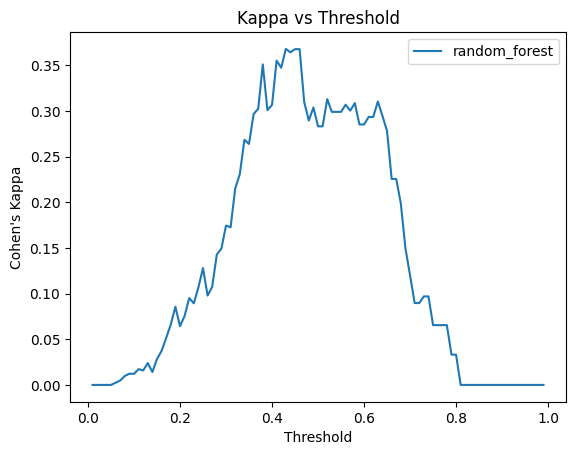

In [171]:
analista_clasificacion_6.plot_cohens_kappa(["random_forest"])

# 4. Model comparison and discussion

Create total results dataframe for model comparison.

In [221]:
df_total = pd.DataFrame()
for i in range(1, 7):
    # use locals variable dict to dinamically access the analista_clasificacion objects
    analista_clasificacion_i = locals().get(f"analista_clasificacion_{i}")

    for model_name, model in models.items():
        try:
            df_metricas = analista_clasificacion_i.calcular_metricas(model_name)
            df_metricas["model"] = model_name
            df_metricas["iteration"] = analista_clasificacion_i.iteracion
            df_total = pd.concat([df_total,df_metricas],axis=0)
        except:
            continue

# get train_test column
df_total = (df_total.reset_index()
            .rename(columns={"index":"train_test"})
            .sort_values(by=["model","iteration"])
            .style.apply(sac.color_filas_por_modelo, axis=1))
df_total

,train_test,accuracy,precision,recall,f1,kappa,auc,average_precision,model_mean_fit_time,model_mean_score_time,n_jobs,model,iteration
12,train,0.889507,0.895484,0.889507,0.866224,0.444442,0.917750,0.782561,9.549240,0.014504,12.000000,catboost,iteration3
13,test,0.879365,0.885250,0.879365,0.849273,0.361940,0.753660,0.530867,9.549240,0.014504,12.000000,catboost,iteration3
14,train,0.911765,0.920157,0.911765,0.897254,0.579188,0.983217,0.945950,17.572955,0.017063,12.000000,catboost,iteration4
15,test,0.860317,0.852407,0.860317,0.818658,0.225698,0.762792,0.504613,17.572955,0.017063,12.000000,catboost,iteration4
16,train,0.880763,0.905812,0.880763,0.888556,0.621358,0.942535,0.801837,9.369516,0.013526,12.000000,catboost,iteration5
17,test,0.822222,0.845848,0.822222,0.831716,0.410822,0.761434,0.500947,9.369516,0.013526,12.000000,catboost,iteration5
0,train,0.878378,0.868413,0.878378,0.857853,0.416961,0.892812,0.642511,0.324669,0.062769,12.000000,decision_tree,iteration1
1,test,0.819048,0.760918,0.819048,0.779788,0.074723,0.647774,0.256344,0.324669,0.062769,12.000000,decision_tree,iteration1
6,train,0.841812,0.800990,0.841812,0.791875,0.118533,0.667815,0.335310,0.265975,0.081883,12.000000,decision_tree,iteration2
7,test,0.825397,0.761969,0.825397,0.779821,0.065786,0.647283,0.272054,0.265975,0.081883,12.000000,decision_tree,iteration2


Now, with the results from the evaluations performed until now, let's visually inspect observe which have performed best.

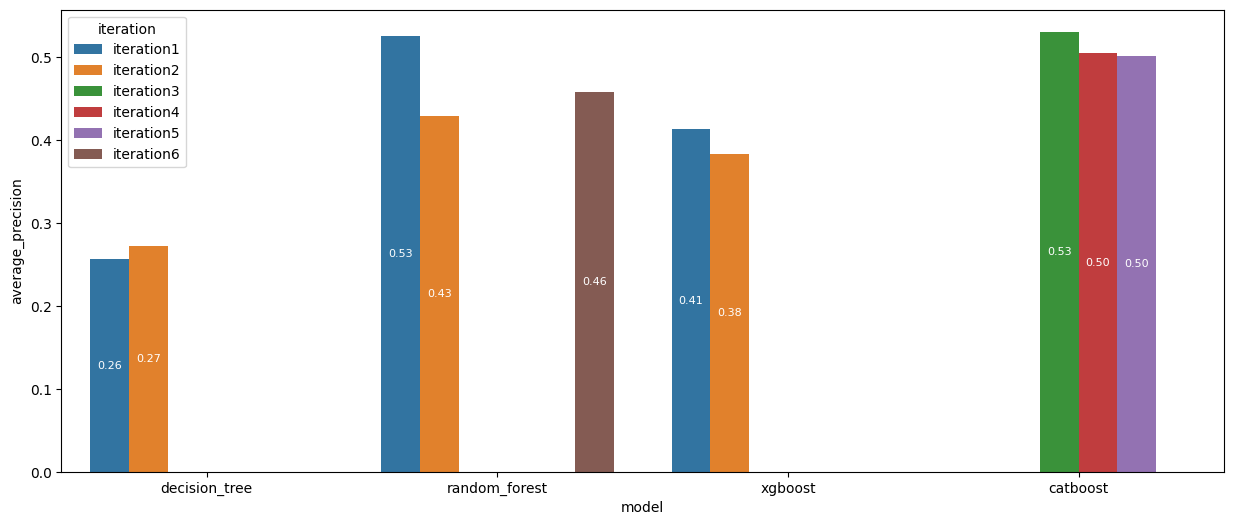

In [210]:
plt.figure(figsize=(15,6))
ax = sns.barplot(data=df_total[df_total["index"]=="test"],
            x="model",
            y="average_precision",
            hue="iteration")
dvs.plot_bar_labels(ax)
plt.show()

From the above graph, it is clear that overall, Catboost is a phenomenal algorithm that does not need much tuning. In fact, the best iteration of all is the one where just small v

# 4. Selección de mejor threshold y calibración de modelo